In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
#With discharge
file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\y_obs.csv'
y_obs = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_obs.set_index(y_obs.columns[0],inplace=True)

file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\y_sim.csv'
y_sim = pd.read_csv(file_path, parse_dates=[0])

file_path = r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\NSE.csv'
nse_disch = pd.read_csv(file_path)
# Set the unnamed first column (dates) as the index
y_sim.set_index(y_sim.columns[0],inplace=True)

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    # Initialize a dictionary to store precipitation indices
    indices = {}

    # Total precipitation amount averaged over all days
    indices['avgprcp'] = series.sum(skipna=True) / series.count()

    # Average precipitation amount for rainy days (precipitation > 1 mm)
    rainy_days = series[series > 1]
    indices['avgprcp_rainy'] = rainy_days.mean() if not rainy_days.empty else np.nan

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 90th percentile of non-zero precipitation
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile of non-zero precipitation
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    # 25th percentile of daily precipitation
    indices['r25p'] = series.quantile(0.25)

    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB - Runs above and below the median
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()

    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()

    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z
    else:
        indices['RUNAB'] = np.nan  # Set to NaN if not enough data

    # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr

    return pd.Series(indices)

In [5]:
# Apply the precipitation indices function to each catchment column for y_obs
results_era5 = y_obs.apply(calculate_precipitation_indices, axis=0).T
results_era5['Catchment'] = results_era5.index

# Apply the precipitation indices function to each catchment column for y_sim
results_y_sim = y_sim.apply(calculate_precipitation_indices, axis=0).T
results_y_sim['Catchment'] = results_y_sim.index


C:\Users\ashis\AppData\Local\Temp\ipykernel_2176\2784419418.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2176\2784419418.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2176\2784419418.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2176\2784419418.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2176\2784419418.py:11: RuntimeWarning: invalid value encountered in double_scalars
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
C:\Users\ashis\AppData\Local\Temp\ipykernel_2

In [6]:
# Rename columns for clarity before merging
results_era5_renamed = results_era5.rename(columns=lambda x: f"era5_{x}")
results_y_sim_renamed = results_y_sim.rename(columns=lambda x: f"y_sim_{x}")

# Merge the DataFrames
combined_results = pd.merge(results_era5_renamed, results_y_sim_renamed, left_index=True, right_index=True)

# Reset index if needed, for easier manipulation
combined_results.reset_index(inplace=True)

# Display the merged DataFrame
print(combined_results.head())



          index  era5_avgprcp  era5_avgprcp_rainy  era5_r90p  era5_r90p_1  \
0  GRDC_6140100      2.383335            5.107542      6.770       11.283   
1  GRDC_6140101      2.279040            5.005228      6.540       10.670   
2  GRDC_6140120      2.285547            5.252399      6.822       11.150   
3  GRDC_6140130      3.103167            6.037563      9.022       12.608   
4  GRDC_6140140      2.998241            5.969102      8.710       12.456   

   era5_r95p  era5_r95p_1  era5_r25p  era5_rx1day  era5_rx5day  ...  \
0     10.571      14.7105       0.07        46.24       101.48  ...   
1      9.980      14.6275       0.06        46.73        97.38  ...   
2     10.170      14.8910       0.04        60.86       104.07  ...   
3     12.545      16.6475       0.08        53.13       112.26  ...   
4     12.312      16.2920       0.06        59.22       107.06  ...   

   y_sim_rx1day  y_sim_rx5day  y_sim_r10mm  y_sim_r20mm  y_sim_wetdays  \
0     35.297676     97.156166       

In [8]:
combined_results.to_csv(r'C:\Users\ashis\Github\lstm_backward\results\with_discharge\measures_era5_lstm.csv')

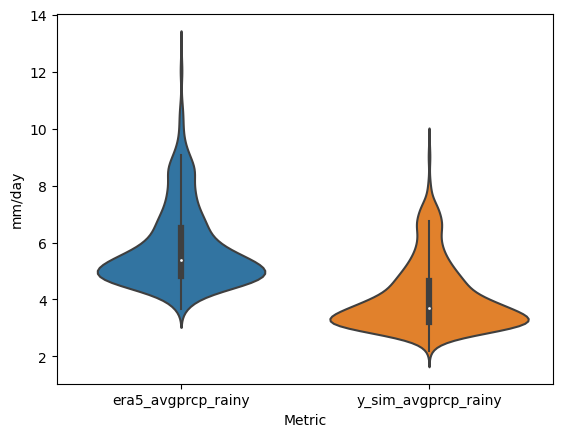

In [13]:
# Set the two columns you want to plot
column1 = 'era5_avgprcp_rainy'
column2 = 'y_sim_avgprcp_rainy'

# Combine the two columns into one long-form DataFrame
df_melted = pd.melt(combined_results, value_vars=[column1, column2], var_name='Metric', value_name='mm/day')

# Create the violin plot
sns.violinplot(x='Metric', y='mm/day', data=df_melted)

# Customize the plot
plt.show()

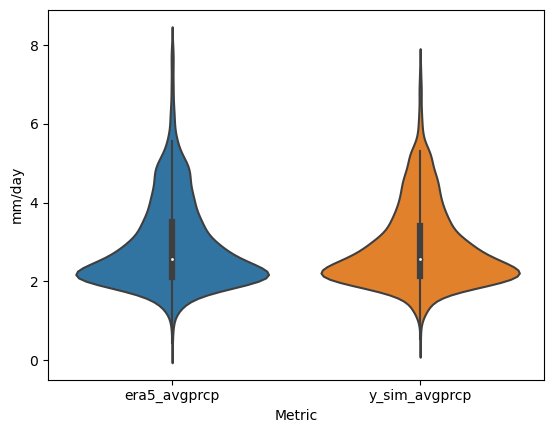

In [14]:
# Set the two columns you want to plot
column1 = 'era5_avgprcp'
column2 = 'y_sim_avgprcp'

# Combine the two columns into one long-form DataFrame
df_melted = pd.melt(combined_results, value_vars=[column1, column2], var_name='Metric', value_name='mm/day')

# Create the violin plot
sns.violinplot(x='Metric', y='mm/day', data=df_melted)

# Customize the plot
plt.show()